In [1]:
import sys  
sys.path.append('./scripts/')
from mcl import *
from kf import *

In [2]:
# ガウス分布のパラメータを表示
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0) # 姿勢を元のクラスのposeに設定
        self.cov = None #共分散行列の共分散にNoneを割り当てる
        
    def draw(self, ax, elems): 
        if self.cov is None: #　共分散が設定されていない時は描画しない
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

In [3]:
# FastSLAM用のパーティクル
class MapParticle(Particle):
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map() # パーティクルに地図をもたせる（m^_t(i)に相当）
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
        # 地図に指定された個数だけself.mapにガウス分布のパラメータを表すEstimatedLandmarkクラスのオブジェクトをもたせる
    
    # ランドマークの初期値の設定
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        x, y, t = self.pose # パーティクルの姿勢
        ell, phi = z # センサの観測値を距離と角度の成分に分離
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y # 観測値から導いた計測対象のランドマークの世界座標系での位置
        
        # 観測方程式hを最新のセンサ値から求めたランドマークの位置推定まわりで偏微分したものであり, Σt導出する要素
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        # ガウス分布における雑音の共分散行列Q_m
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H)) # 時刻tにおける共分散行列Σt
        landmark.pos = np.array([mx, my]).T # 時刻tにおける記録されたランドマークの位置
        
        '''
        ランドマークの推定の実装には, あるランドマークを初めて観測した時にガウス分布を設定するかの問題がある.
        そこで, 分布の広いガウス分布を与え, 後で更新則に基づき計算する方法を使用することで, 初期化が不要になる.
        このとき, 計算の途中に線形化が含まれているとうまくいかないことがある.
        そのため, センサ値しか情報がない状況を考え, カルマンフィルタの更新ステップと同様に計算することで初期値を導出する.
        '''
    
    # ランドマーク推定の更新
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):
        # 更新則に基づく更新
        x, y, _ = self.pose # 現在のパーティクルの姿勢
        mx, my =  landmark.pos # t-1でのランドマークの世界座標系での位置
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos) # ロボットの姿勢とランドマークの位置よりセンサ入力zを取得
        estm_ell, _ = estm_z # センサの観測値の距離成分のみ代入
        
        # センサの距離成分が十分に小さい時は更新しない
        if estm_ell < 0.01:
            return
        
        # 観測方程式hをm^_t(i-1)周りで偏微分したもの
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        # ガウス分布における雑音の共分散行列Q_m
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        # カルマンゲイン
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
        '''
        t-1でのパーティクルの位置landmark.posと共分散行列landmark.covを元にランドマークの位置推定の更新を行う
        導出に必要なH,Q,Kを計算し, 重みの更新およびランドマークの推定の更新を行う
        '''
    
    # ランドマークの更新
    def observation_update(self, observation, distance_dev_rate, direction_dev):
        # for文をまわして, ランドマークが初観測であればinit_landmark_estimationを呼び出す
        # 二回目以降であればobservation_update_landmarkを呼び出し更新を行う
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [4]:
# FastSLAMを実行するエージェント
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        # particle_num:パーティクルの数
        # init_pose:初期姿勢
        # landmark_num:環境中のランドマークの数を数えるための変数
        # motion_noise_stds:パーティクルの動きに生じる雑音の標準偏差
        # distance_dev_rate:センサの距離方向の雑音の標準偏差
        # direction_dev:センサの角度方向の雑音の標準偏差
        
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0] # 最尤のパーティクルを新しく作ったパーティクルのリストの先頭にしておく
    
    def observation_update(self, observation):  
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev)
        self.set_ml()
        self.resampling() 
        
    def draw(self, ax, elems): # パーティクルを描画する関数
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems) # 重みが最大のパーティクルを持つつづを描画

<IPython.core.display.Javascript object>


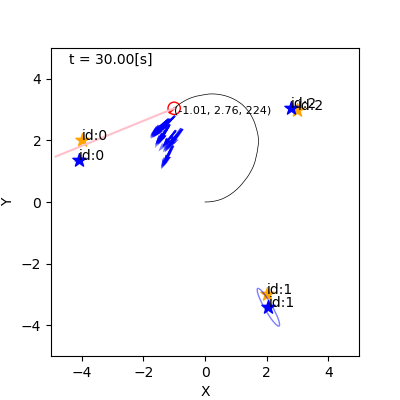

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(100, init_pose, len(m.landmarks))
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [6]:
a.pf.particles[10].map.landmarks[2].cov

In [7]:
math.sqrt(0.0025)

0.05